In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib
from astropy.table import Table

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

# The Goal:
Remake this plot that Schmidt and I made one evening, many years ago.... but with MORE data!

Then, have a tool to compute metallicity for "all" Gaia stars!

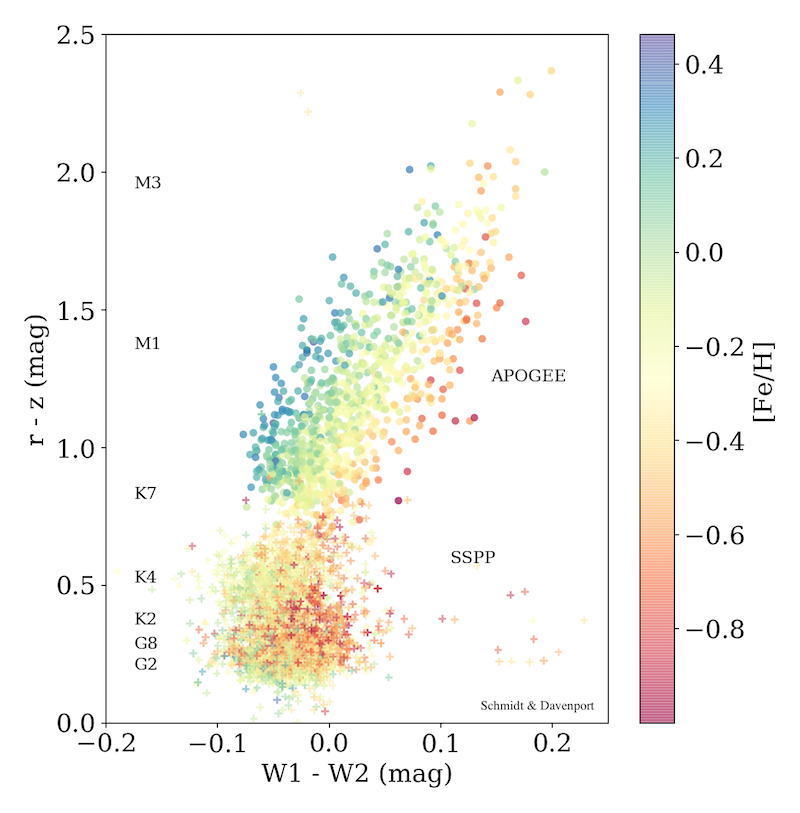

In [3]:
from IPython.display import Image
Image(filename='./w1w2_rz_feh.png', width=500) 

## Step 1: X-match
We need to combine the SSPP and APOGEE properties tables with:
- Gaia DR2
- AllWISE

Hopefully both tables have SDSS colors.......

**Q:** Can I combine both `(ra,dec)` lists and do 1 X-match for both catalogs?

### SDSS first

In [158]:
# #umm... are these dwarfs? Nothing with logg>=4... boo
# da = np.where((apog['LOGG'] >= 3.3) & (apog['FE_H'] > -5))[0]

# plt.scatter(apog['TEFF'][da], apog['J'][da] - apog['WISE_4_5'][da], 
#             c=apog['FE_H'][da], s=5, alpha=0.5)
# plt.ylim(0,1.5)
# plt.xlim(5700,4000)
# plt.ylabel('J - W2')
# plt.xlabel('Teff')
# cb=plt.colorbar()
# cb.set_label('[Fe/H]')

In [4]:
sdss = Table.read('/Users/james/Desktop/gaia_tmp/ssppOut-dr12.fits', format='fits')

In [12]:
# sdss.colnames

(6, -2)

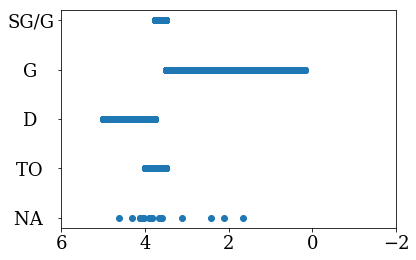

In [6]:
plt.scatter(sdss['LOGG_ADOP'], sdss['L_CLASS'])
plt.xlim(6,-2)

In [85]:
xyok = np.where((sdss['RA'] >= 0) & (sdss['RA'] <= 360) & 
                (sdss['DEC'] >= -90) & (sdss['DEC'] <= 90))[0]
# df_out = pd.DataFrame(data={'ra':sdss['RA'][xyok], 'dec':sdss['DEC'][xyok]})
# df_out.to_csv('sspp_toX.csv')

In [11]:
Xgaia = pd.read_csv('/Users/james/Desktop/gaia_tmp/Xgaia.csv')
Xwise = pd.read_csv('/Users/james/Desktop/gaia_tmp/Xwise.csv')

In [14]:
Xwise.columns

Index([u'angDist', u'id', u'dec', u'ra', u'AllWISE', u'RAJ2000', u'DEJ2000',
       u'eeMaj', u'eeMin', u'eePA', u'W1mag', u'W2mag', u'W3mag', u'W4mag',
       u'Jmag', u'Hmag', u'Kmag', u'e_W1mag', u'e_W2mag', u'e_W3mag',
       u'e_W4mag', u'e_Jmag', u'e_Hmag', u'e_Kmag', u'ID', u'ccf', u'ex',
       u'var', u'qph', u'pmRA', u'e_pmRA', u'pmDE', u'e_pmDE', u'd2M'],
      dtype='object')

In [15]:
Xgaia.columns

Index([u'angDist', u'id', u'dec', u'ra', u'ra_epoch2000', u'dec_epoch2000',
       u'errHalfMaj', u'errHalfMin', u'errPosAng', u'source_id', u'ra.1',
       u'ra_error', u'dec.1', u'dec_error', u'parallax', u'parallax_error',
       u'pmra', u'pmra_error', u'pmdec', u'pmdec_error', u'duplicated_source',
       u'phot_g_mean_flux', u'phot_g_mean_flux_error', u'phot_g_mean_mag',
       u'phot_bp_mean_flux', u'phot_bp_mean_flux_error', u'phot_bp_mean_mag',
       u'phot_rp_mean_flux', u'phot_rp_mean_flux_error', u'phot_rp_mean_mag',
       u'bp_rp', u'radial_velocity', u'radial_velocity_error', u'teff_val',
       u'a_g_val', u'e_bp_min_rp_val', u'radius_val', u'lum_val'],
      dtype='object')

In [100]:
df = sdss[xyok].to_pandas()
tmp_data = pd.merge(Xgaia, Xwise, left_on=u'id', right_on=u'id')
data = pd.merge(df, tmp_data, how='inner', left_on=np.arange(len(df)), right_on=u'id')

In [97]:
tmp_data.shape

(882766, 71)

In [101]:
data.shape

(882766, 310)

In [102]:
sum(np.isfinite(data[u'radial_velocity']))

3851

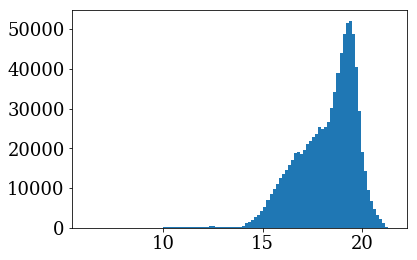

In [104]:
_ = plt.hist(data[u'phot_g_mean_mag'],bins=100)

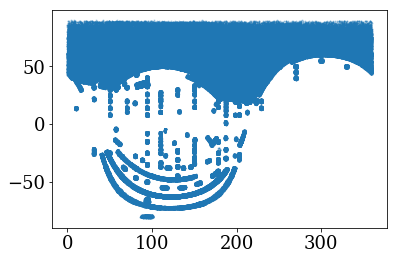

In [105]:
plt.scatter(data[u'L'], data[u'B'], s=1, alpha=0.3)

Text(0.5,1,'SSPP sources')

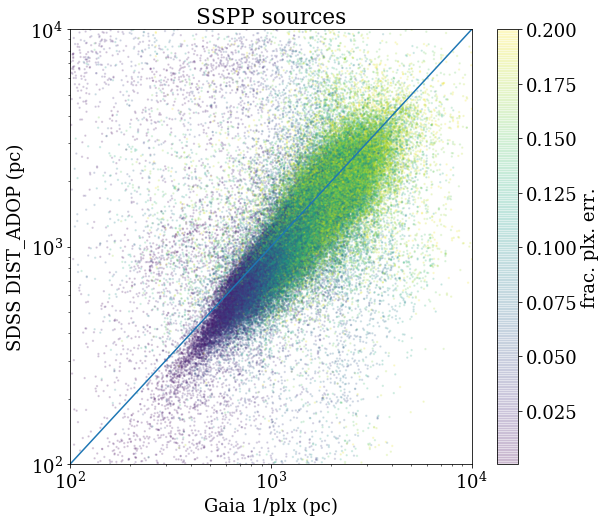

In [112]:
ok = np.where((data[u'parallax_error']/data[u'parallax'] <= 0.2) & 
              (data[u'parallax'] > 0))[0]

plt.figure(figsize=(9,8))
plt.scatter(1000./data[u'parallax'][ok], data[u'DIST_ADOP'][ok]*1000., s=2, alpha=0.15, 
            c=data[u'parallax_error'][ok]/data[u'parallax'][ok])
plt.xlabel('Gaia 1/plx (pc)')
plt.ylabel('SDSS DIST_ADOP (pc)')
plt.plot([1,1e4], [1,1e4])
cb = plt.colorbar()
cb.set_label('frac. plx. err.')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e2,1e4)
plt.xlim(1e2,1e4)
plt.title('SSPP sources')

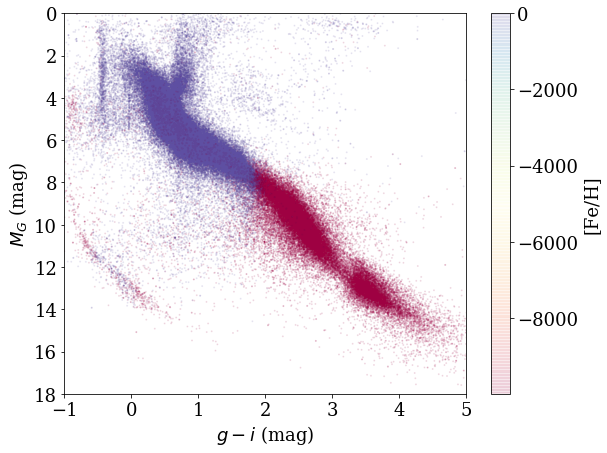

In [123]:
plt.figure(figsize=(9,7))

plt.scatter(data[u'GR'].values[ok]+data[u'RI'].values[ok], 
            (data[u'phot_g_mean_mag'].values[ok] - 
             5*np.log10(1000./data[u'parallax'].values[ok])+5),
            s=1, alpha=0.1, c=data[u'FEH_ADOP'].values[ok], cmap=plt.cm.Spectral)
cb = plt.colorbar()
plt.ylim(18,0)
plt.xlim(-1,5)
plt.xlabel('$g-i$ (mag)')
plt.ylabel(r'$M_G$ (mag)')
cb.set_label('[Fe/H]')

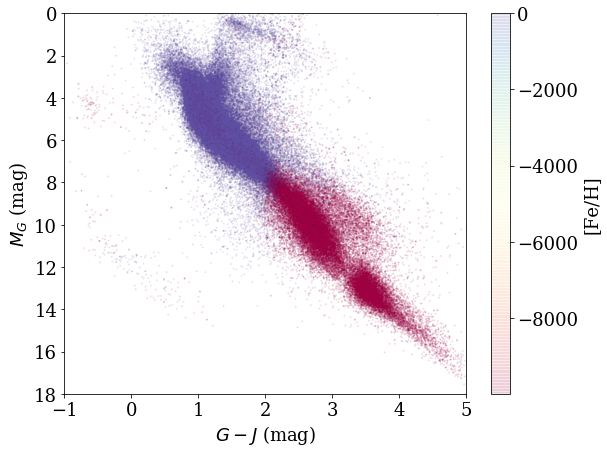

In [215]:
plt.figure(figsize=(9,7))

plt.scatter(data[u'phot_g_mean_mag'].values[ok] - data[u'Jmag'].values[ok], 
            (data[u'phot_g_mean_mag'].values[ok] - 
             5*np.log10(1000./data[u'parallax'].values[ok])+5),
            s=1, alpha=0.1, c=data[u'FEH_ADOP'].values[ok], cmap=plt.cm.Spectral)
cb = plt.colorbar()
plt.ylim(18,0)
plt.xlim(-1,5)
plt.xlabel('$G - J$ (mag)')
plt.ylabel(r'$M_G$ (mag)')
cb.set_label('[Fe/H]')

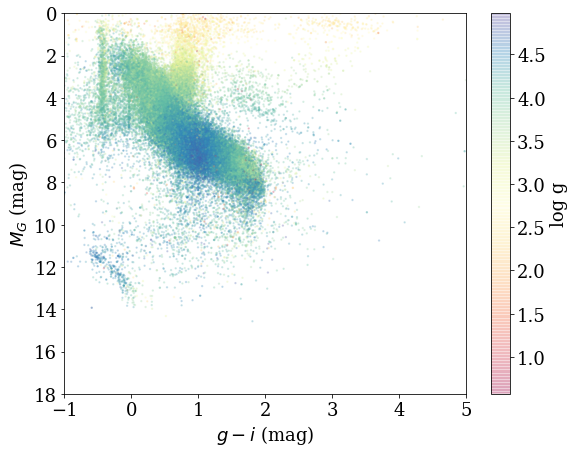

In [138]:
fok = np.where((data[u'FEH_ADOP'].values[ok] > -6))

M_G = (data[u'phot_g_mean_mag'].values[ok] - 
       5*np.log10(1000./data[u'parallax'].values[ok])+5)

plt.figure(figsize=(9,7))

plt.scatter(data[u'GR'].values[ok][fok]+data[u'RI'].values[ok][fok], 
            M_G[fok],
            s=2, alpha=0.2, c=data[u'LOGG_ADOP'].values[ok][fok], cmap=plt.cm.Spectral)

cb = plt.colorbar()
plt.ylim(18,0)
plt.xlim(-1,5)
plt.xlabel('$g-i$ (mag)')
plt.ylabel(r'$M_G$ (mag)')
cb.set_label('log g')

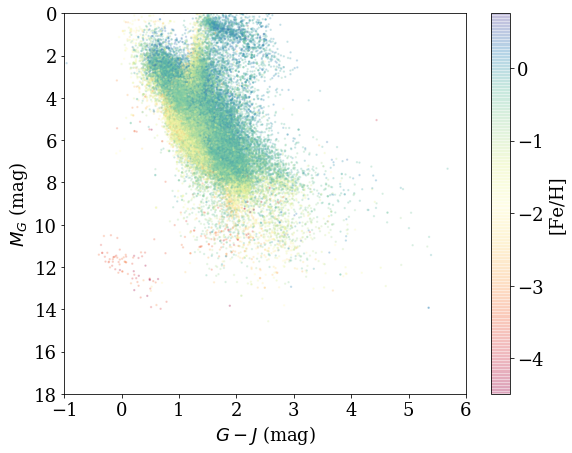

In [228]:
plt.figure(figsize=(9,7))

plt.scatter(data[u'phot_g_mean_mag'].values[ok][fok] - data[u'Jmag'].values[ok][fok], 
            M_G[fok],
            s=2, alpha=0.2, c=data[u'FEH_ADOP'].values[ok][fok], cmap=plt.cm.Spectral)

cb = plt.colorbar()
plt.ylim(18,0)
plt.xlim(-1,6)
plt.xlabel('$G-J$ (mag)')
plt.ylabel(r'$M_G$ (mag)')
cb.set_label('[Fe/H]')

Text(0,0.5,'$g-i$')

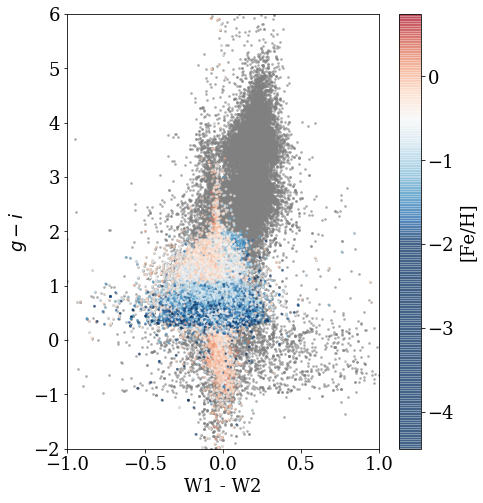

In [159]:
plt.figure(figsize=(7,8))
plt.scatter(data[u'W1mag'].values[ok] - data[u'W2mag'].values[ok], 
            data[u'GR'].values[ok] + data[u'RI'].values[ok], 
            s=3, alpha=0.5, c='gray')

plt.scatter(data[u'W1mag'].values[ok][gok] - data[u'W2mag'].values[ok][gok], 
            data[u'GR'].values[ok][gok] + data[u'RI'].values[ok][gok], 
            c=data[u'FEH_ADOP'].values[ok][gok], s=3, alpha=0.5, cmap=plt.cm.RdBu_r)

cb = plt.colorbar()
cb.set_label('[Fe/H]')
cb.set_clim((-2,1))
plt.xlim(-1,1)
plt.ylim(-2,6)
plt.xlabel('W1 - W2')
plt.ylabel('$g-i$')

In [252]:
gok = np.where((data[u'FEH_ADOP'].values[ok] > -6) & 
               (M_G > 4) & (M_G < 9) & 
               np.isfinite(data[u'a_g_val'].values[ok]) & 
               (data[u'a_g_val'].values[ok] < 0.5))


/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less


Text(0.5,0,'$g-i$')

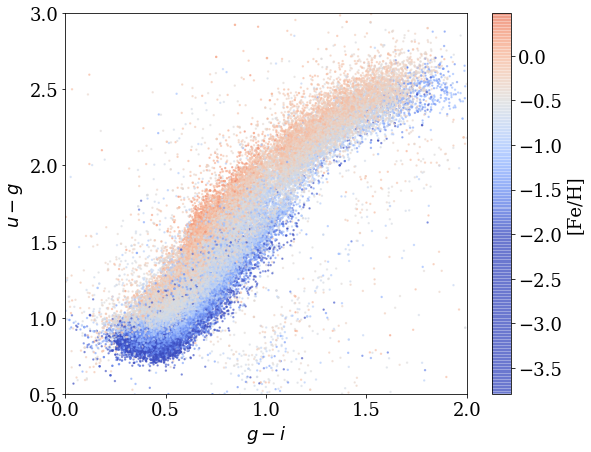

In [253]:
plt.figure(figsize=(9,7))
plt.scatter(data[u'GR'].values[ok][gok] + data[u'RI'].values[ok][gok], 
            data[u'UG'].values[ok][gok],
            c=data[u'FEH_ADOP'].values[ok][gok], s=2, alpha=0.5, cmap=plt.cm.coolwarm)

cb = plt.colorbar()
cb.set_label('[Fe/H]')
cb.set_clim((-2,1))
plt.xlim(0,2)
plt.ylim(0.5,3)
plt.ylabel('$u-g$')
plt.xlabel('$g-i$')

Text(0.5,0,'$G-J$')

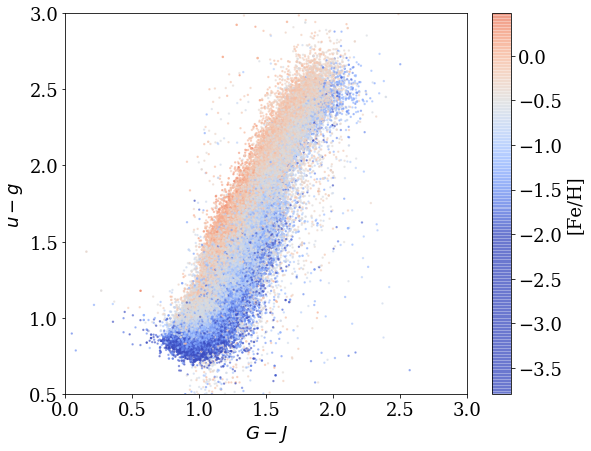

In [254]:
plt.figure(figsize=(9,7))
plt.scatter(data[u'phot_g_mean_mag'].values[ok][gok] - data[u'Jmag'].values[ok][gok], 
            data[u'UG'].values[ok][gok],
            c=data[u'FEH_ADOP'].values[ok][gok], s=2, alpha=0.5, cmap=plt.cm.coolwarm)

cb = plt.colorbar()
cb.set_label('[Fe/H]')
cb.set_clim((-2,1))
plt.xlim(0,3)
plt.ylim(0.5,3)
plt.ylabel('$u-g$')
plt.xlabel('$G-J$')

### APOGEE next

In [170]:
apog = Table.read('/Users/james/Desktop/gaia_tmp/allStar-l31c.2.fits', format='fits')

In [202]:
# apog.colnames

In [171]:
xyokA = np.where((apog['RA'] >= 0) & (apog['RA'] <= 360) & 
                 (apog['DEC'] >= -90) & (apog['DEC'] <= 90))[0]
# df_outA = pd.DataFrame(data={'ra':apog['RA'][xyokA], 'dec':apog['DEC'][xyokA]})
# df_outA.to_csv('apog_toX.csv')

In [174]:
Agaia = pd.read_csv('/Users/james/Desktop/gaia_tmp/Agaia.csv')
Awise = pd.read_csv('/Users/james/Desktop/gaia_tmp/Awise.csv')

In [199]:
# need to select out columns i want, b/c multi-D cols messing .to_pandas up...
# can fix later...

dfA = apog[xyokA]['J','J_ERR','H', 'H_ERR', 'K', 'K_ERR', 
                  'RA', 'DEC', 'GLON', 'GLAT', 'TEFF', 'LOGG', 'FE_H'].to_pandas()


In [201]:
tmp_dataA = pd.merge(Agaia, Awise, left_on=u'id', right_on=u'id')
Adata = pd.merge(dfA, tmp_dataA, how='inner', left_on=np.arange(len(dfA)), right_on=u'id')

In [203]:
Adata.columns

Index([u'J', u'J_ERR', u'H', u'H_ERR', u'K', u'K_ERR', u'RA', u'DEC', u'GLON',
       u'GLAT', u'TEFF', u'LOGG', u'FE_H', u'angDist_x', u'id', u'dec_x',
       u'ra_x', u'ra_epoch2000', u'dec_epoch2000', u'errHalfMaj',
       u'errHalfMin', u'errPosAng', u'source_id', u'ra.1', u'ra_error',
       u'dec.1', u'dec_error', u'parallax', u'parallax_error', u'pmra',
       u'pmra_error', u'pmdec', u'pmdec_error', u'duplicated_source',
       u'phot_g_mean_flux', u'phot_g_mean_flux_error', u'phot_g_mean_mag',
       u'phot_bp_mean_flux', u'phot_bp_mean_flux_error', u'phot_bp_mean_mag',
       u'phot_rp_mean_flux', u'phot_rp_mean_flux_error', u'phot_rp_mean_mag',
       u'bp_rp', u'radial_velocity', u'radial_velocity_error', u'teff_val',
       u'a_g_val', u'e_bp_min_rp_val', u'radius_val', u'lum_val', u'angDist_y',
       u'dec_y', u'ra_y', u'AllWISE', u'RAJ2000', u'DEJ2000', u'eeMaj',
       u'eeMin', u'eePA', u'W1mag', u'W2mag', u'W3mag', u'W4mag', u'Jmag',
       u'Hmag', u'Kmag', u'e_W1ma

In [221]:
Aok = np.where((Adata[u'FE_H'] > -6))

M_GA = (Adata[u'phot_g_mean_mag'].values[Aok] - 
        5*np.log10(1000./Adata[u'parallax'].values[Aok])+5)

/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in divide
/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log10


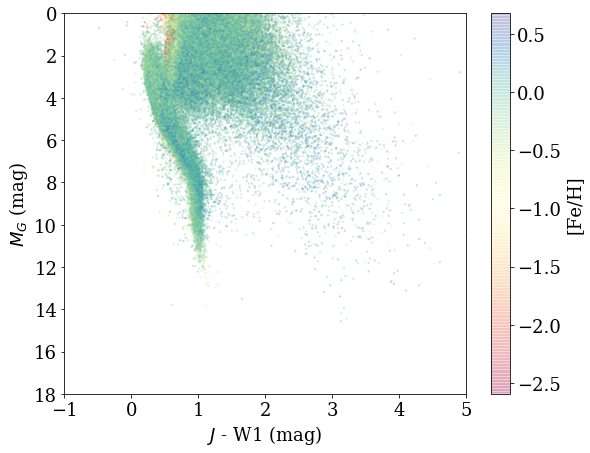

In [223]:
plt.figure(figsize=(9,7))

plt.scatter(Adata[u'Jmag'].values[Aok] - Adata[u'W1mag'].values[Aok], 
            M_GA,
            s=2, alpha=0.2, c=Adata[u'FE_H'].values[Aok], cmap=plt.cm.Spectral)

cb = plt.colorbar()
plt.ylim(18,0)
plt.xlim(-1,5)
plt.xlabel('$J$ - W1 (mag)')
plt.ylabel(r'$M_G$ (mag)')
cb.set_label('[Fe/H]')

uh oh.... no M dwarfs in APOGEE.... (are we missing mid-M's?)

Text(0.5,1,'APOGEE stars')

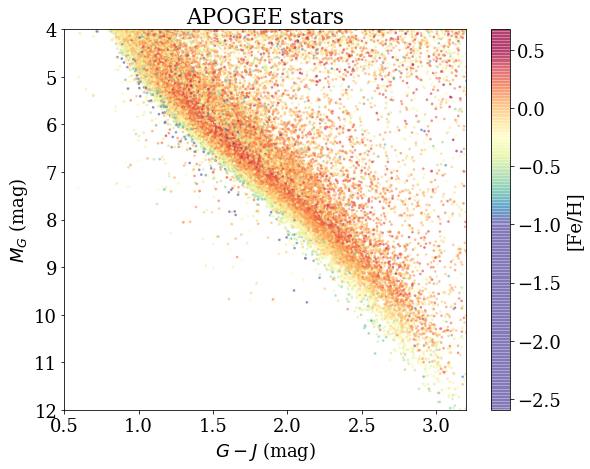

In [240]:
plt.figure(figsize=(9,7))

plt.scatter(Adata[u'phot_g_mean_mag'].values[Aok] - Adata[u'Jmag'].values[Aok], 
            M_GA,
            s=3, alpha=0.5, c=Adata[u'FE_H'].values[Aok], cmap=plt.cm.Spectral_r)

cb = plt.colorbar()
cb.set_clim(-1,0.5)
plt.ylim(12,4)
plt.xlim(0.5,3.2)
plt.xlabel('$G - J$ (mag)')
plt.ylabel(r'$M_G$ (mag)')
cb.set_label('[Fe/H]')
plt.title('APOGEE stars')

/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app
/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


Text(0,0.5,'$G-J$ (mag)')

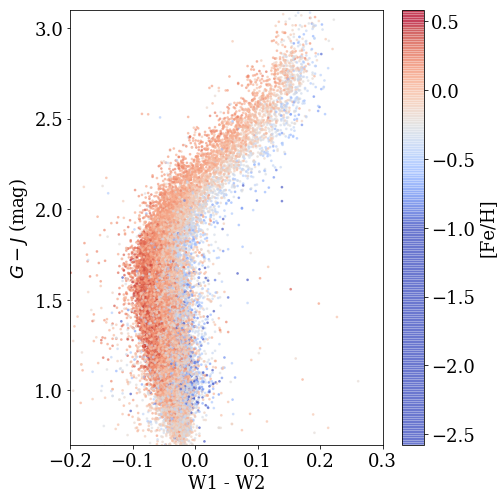

In [263]:
Bok = np.where((M_GA >= 3) & 
               np.isfinite(Adata[u'a_g_val'].values[Aok]) & 
               (Adata[u'a_g_val'].values[Aok] < 0.5))

plt.figure(figsize=(7,8))

plt.scatter(Adata[u'W1mag'].values[Aok][Bok] - Adata[u'W2mag'].values[Aok][Bok], 
            Adata[u'phot_g_mean_mag'].values[Aok][Bok] - Adata[u'Jmag'].values[Aok][Bok],
            c=Adata[u'FE_H'].values[Aok][Bok], s=3, alpha=0.5, cmap=plt.cm.coolwarm)

cb = plt.colorbar()
cb.set_label('[Fe/H]')
cb.set_clim(-1,0.5)
plt.xlim(-0.2,0.3)
plt.ylim(0.7, 3.1)
plt.xlabel('W1 - W2')
plt.ylabel('$G-J$ (mag)')

### NOW BOTH

er... **nope!** The SDSS data looks like crap in WISE colors. Alas.

Can we find a better color space in the red that [Fe/H] stands out in?

No

Text(0,0.5,'$G-J$ (mag)')

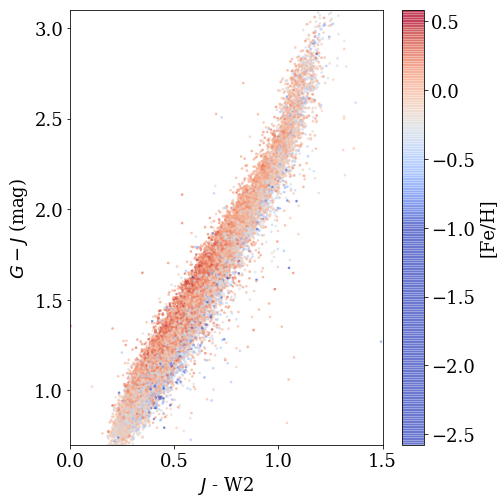

In [273]:
plt.figure(figsize=(7,8))

plt.scatter(Adata[u'Jmag'].values[Aok][Bok] - Adata[u'W2mag'].values[Aok][Bok], 
            Adata[u'phot_g_mean_mag'].values[Aok][Bok] - Adata[u'Jmag'].values[Aok][Bok],
            c=Adata[u'FE_H'].values[Aok][Bok], s=3, alpha=0.5, cmap=plt.cm.coolwarm)

cb = plt.colorbar()
cb.set_label('[Fe/H]')
cb.set_clim(-1,0.5)
plt.xlim(0,1.5)
plt.ylim(0.7, 3.1)
plt.xlabel('$J$ - W2')
plt.ylabel('$G-J$ (mag)')